In [16]:
import pandas as pd

# Load dataset
df = pd.read_csv("soc-sign-bitcoinotc.csv", header=None, names=["source", "target", "rating", "timestamp"])


# Preview
print(df.head())
print(df.info())


   source  target  rating     timestamp
0       6       2       4  1.289242e+09
1       6       5       2  1.289242e+09
2       1      15       1  1.289243e+09
3       4       3       7  1.289245e+09
4      13      16       8  1.289254e+09
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35592 entries, 0 to 35591
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source     35592 non-null  int64  
 1   target     35592 non-null  int64  
 2   rating     35592 non-null  int64  
 3   timestamp  35592 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 1.1 MB
None


In [10]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("soc-sign-bitcoinotc.csv", header=None, names=["source", "target", "rating", "timestamp"])

# Convert timestamp to datetime
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

# Sort by sender and time
df = df.sort_values(by=["source", "datetime"])

# Time since last transaction per sender
df["prev_txn_time"] = df.groupby("source")["datetime"].shift(1)
df["time_diff_sec"] = (df["datetime"] - df["prev_txn_time"]).dt.total_seconds()

# Count of transactions per sender/receiver
df["sender_txn_count"] = df.groupby("source").cumcount() + 1
df["receiver_txn_count"] = df.groupby("target").cumcount() + 1

# Rolling average trust score
df["sender_avg_rating"] = df.groupby("source")["rating"].expanding().mean().reset_index(level=0, drop=True)
df["receiver_avg_rating"] = df.groupby("target")["rating"].expanding().mean().reset_index(level=0, drop=True)

# Unique receivers (social diversity)
df["unique_receivers"] = df.groupby("source")["target"].apply(
    lambda x: x.expanding().apply(lambda s: len(set(s)), raw=False)
).reset_index(level=0, drop=True)

# Fill NA values
df.fillna(0, inplace=True)

# Save processed dataset
df.to_csv("processed_bitcoinotc.csv", index=False)


C:\Users\Kunal Vishwa\AppData\Local\Temp\ipykernel_2316\2866900466.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df.fillna(0, inplace=True)


C:\Users\Kunal Vishwa\AppData\Local\Temp\ipykernel_2316\1562605037.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["prev_txn_time"] = pd.to_datetime(df["prev_txn_time"], errors='coerce')


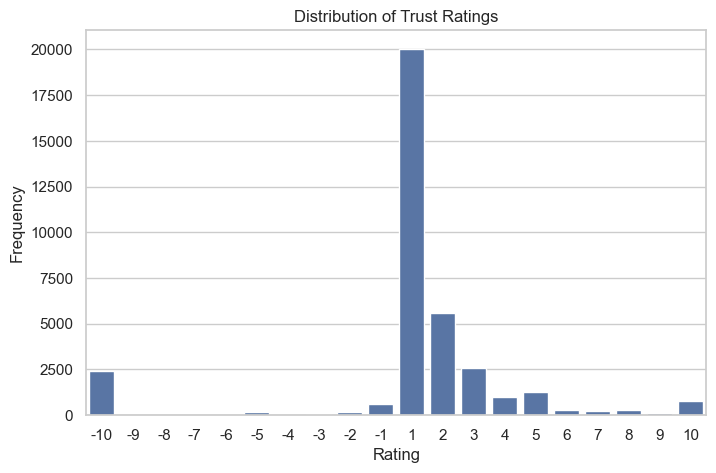

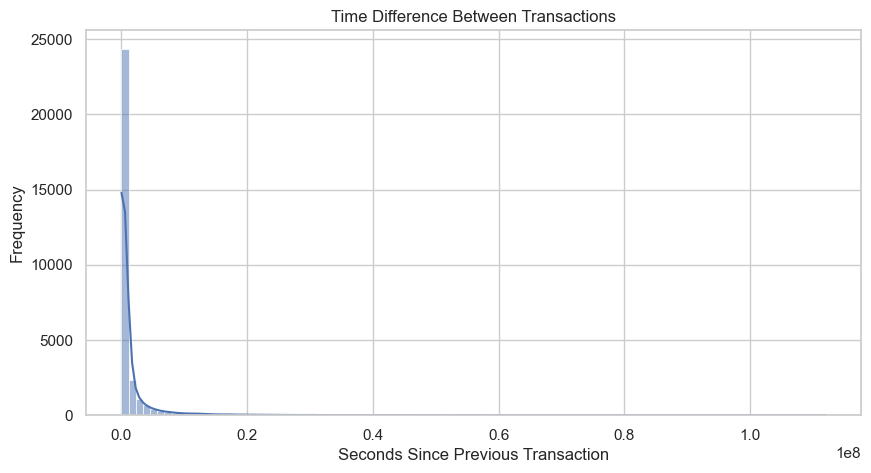

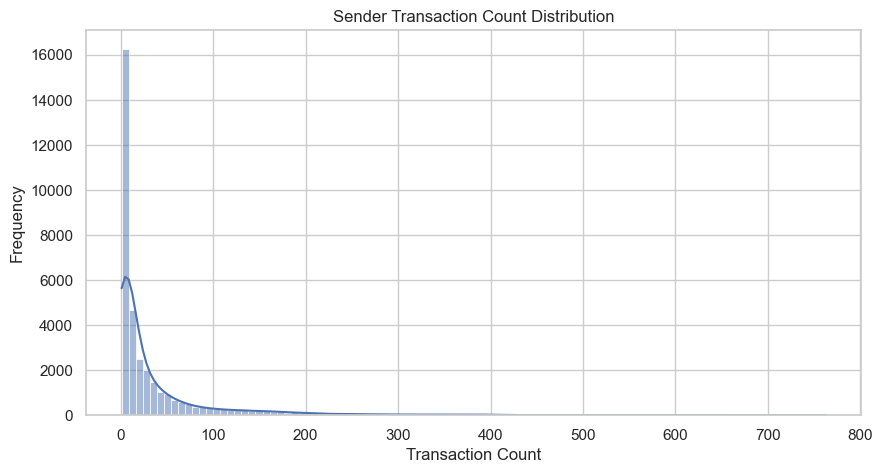

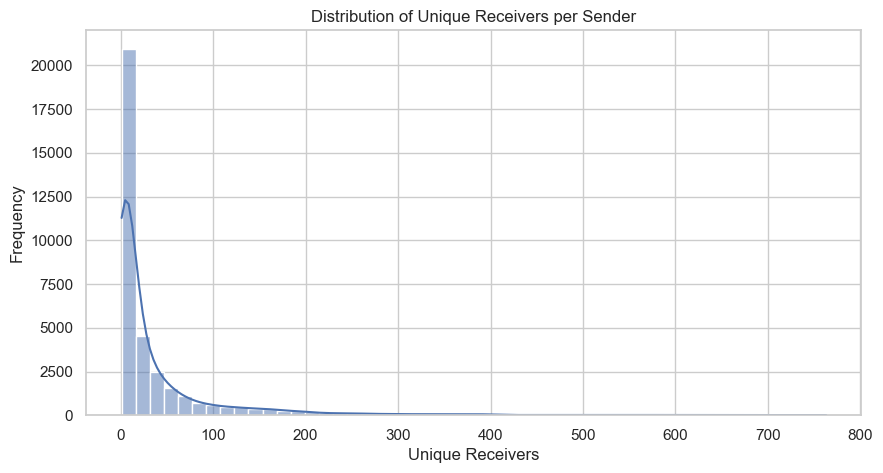

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the processed dataset
df = pd.read_csv("processed_bitcoinotc.csv")

# Convert datetime columns (they may be read as strings)
df["datetime"] = pd.to_datetime(df["datetime"], errors='coerce')
df["prev_txn_time"] = pd.to_datetime(df["prev_txn_time"], errors='coerce')

# Seaborn style
sns.set(style="whitegrid")

# ----- 1. Trust Rating Distribution -----
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="rating")
plt.title("Distribution of Trust Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

# ----- 2. Time Difference Between Transactions -----
# Clean 'time_diff_sec' for valid values only
df_cleaned = df[
    df['time_diff_sec'].notna() &
    np.isfinite(df['time_diff_sec']) &
    (df['time_diff_sec'] > 0)
]

plt.figure(figsize=(10, 5))
sns.histplot(df_cleaned["time_diff_sec"], bins=100, kde=True)
plt.title("Time Difference Between Transactions")
plt.xlabel("Seconds Since Previous Transaction")
plt.ylabel("Frequency")
plt.show()

# ----- 3. Sender Transaction Count Distribution -----
plt.figure(figsize=(10, 5))
sns.histplot(df["sender_txn_count"], bins=100, kde=True)
plt.title("Sender Transaction Count Distribution")
plt.xlabel("Transaction Count")
plt.ylabel("Frequency")
plt.show()

# ----- 4. Unique Receivers per Sender -----
plt.figure(figsize=(10, 5))
sns.histplot(df["unique_receivers"], bins=50, kde=True)
plt.title("Distribution of Unique Receivers per Sender")
plt.xlabel("Unique Receivers")
plt.ylabel("Frequency")
plt.show()



In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

# Select modeling features
features = [
    'time_diff_sec',
    'sender_txn_count',
    'receiver_txn_count',
    'sender_avg_rating',
    'receiver_avg_rating',
    'unique_receivers'
]

# Clean + scale
df_model = df[features].replace([np.inf, -np.inf], np.nan).dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model)

# Train Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.02, random_state=42)
df_model['anomaly_score'] = iso_forest.fit_predict(X_scaled)
df_model['is_anomaly'] = df_model['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_model['pca_1'] = X_pca[:, 0]
df_model['pca_2'] = X_pca[:, 1]

# Print anomaly summary
print("Anomaly Counts (Isolation Forest):")
print(df_model['is_anomaly'].value_counts())


Anomaly Counts (Isolation Forest):
is_anomaly
0    34880
1      712
Name: count, dtype: int64


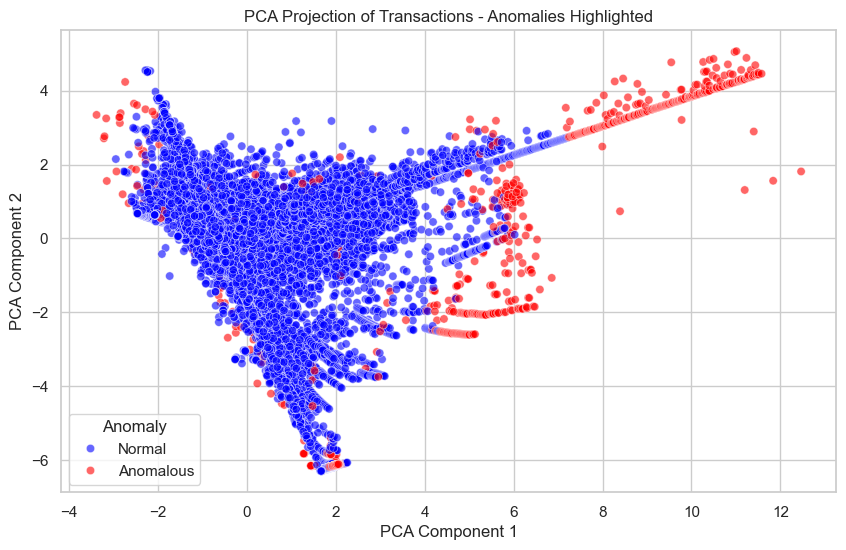

In [21]:
# Save labeled dataset
df_model.to_csv("bitcoinotc_with_isolationforest.csv", index=False)

# Save PCA anomaly plot
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=df_model,
    x='pca_1',
    y='pca_2',
    hue='is_anomaly',
    palette={0: 'blue', 1: 'red'},
    alpha=0.6
)
handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles=handles, labels=["Normal", "Anomalous"], title="Anomaly")
plt.title("PCA Projection of Transactions - Anomalies Highlighted")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.savefig("pca_anomaly_plot_isolationforest.png", dpi=300)
plt.show()
